# Meta-learning classification features: Model

**Imports**

In [79]:
# imports

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

**Classification model**

In [80]:
class ClassificationModel():

    def __init__(self, target_label):

        self.all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                             "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                             "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                             "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                             "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                             "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]

        self.target_label = target_label
        self.dataset = self.load_dataset()
        self.x_train, self.x_test, self.y_train, self.y_test = self.create_train_test_data()
        self.measures = {}

    def load_dataset(self):

        dataset = pd.read_csv("samples_0_6935_all_defects.csv", sep = ",")
        dataset.drop(columns = ["Unnamed: 0", "image_number", "defect_number"], inplace = True)
        dataset.dropna(inplace = True)

        return dataset
    
    def create_train_test_data(self):

        # Create rust labels:
        target_class_df = self.dataset.copy()
        target_class_df["target_label"] = target_class_df["label"].apply(lambda x: 1 if x == self.target_label else 0)

        # Apply train test split:
        target_class_df = target_class_df.sort_values(by = "target_label", ascending = False)
        number_of_defects = target_class_df["target_label"].sum()
        target_class_df_1 = target_class_df.iloc[:number_of_defects, :]
        negative_samples = random.sample(range(number_of_defects, len(target_class_df)), number_of_defects)
        target_class_df_0 = target_class_df.iloc[negative_samples, :]
        df = pd.concat([target_class_df_1, target_class_df_0], ignore_index=True)
        x = df.loc[:, self.all_features]
        y = df.loc[:, "target_label"]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

        return x_train, x_test, y_train, y_test

    def select_features(self, features):

        x_train = self.x_train.loc[:, features]
        x_test = self.x_test.loc[:, features]

        return x_train, x_test
    
    def evaluate(self, y_pred):

        accuracy = accuracy_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred, average=None)[1]

        return accuracy, recall
    
    def run(self, features, number_of_forests=1):

        # Check whether feature combination already exists in measures dictionary:
        feature_combination = ", ".join(sorted(features))
        if feature_combination in self.measures:
            accuracy, recall = self.measures[feature_combination]
        else:

            # Generate train dataset with selected features: 
            x_train, x_test = self.select_features(features)

            # Perform the random forest classifier: 
            for i in range(number_of_forests):
                clf = RandomForestClassifier(n_estimators=50, criterion= "entropy", random_state=i, max_depth=10)
                clf.fit(x_train, self.y_train)
                y_pred = clf.predict(x_test)
                if i == 0:
                    y_pred_final = y_pred
                else:
                    y_pred_final = np.array([1 if y_pred[i] == 1 or y_pred_final[i] == 1 else 0 for i in range(len(y_pred))])

            # Evaluate and store results:
            accuracy, recall = self.evaluate(y_pred_final)
            self.measures[feature_combination] = (accuracy, recall)

        print(f"Feature set: {features}, \nAccuracy: {accuracy}, \nRecall: {recall}\n")
        return recall



**Environment**

In [81]:
class State():

    def __init__(self, state, action=None):

        if not action == None:
            state = self.bitflip(state, action)

        self.binary = state.float()

    def bitflip(self, state, action):

        adjusted_state = state.binary.clone()

        for index in action:
            if state.binary[index] == 0:
                adjusted_state[index] = 1
            else:
                adjusted_state[index] = 0

        return adjusted_state


class Dacl10kEnvironment():

    def __init__(self, classifier, initial_state=None):

        self.all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                             "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                             "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                             "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                             "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                             "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]
        
        self.classifier = classifier
        self.features_dict = {i: feature for i, feature in enumerate(self.all_features)}
        self.statesize = len(self.all_features)

        self.initial_state = State(torch.FloatTensor([i % 2 for i in range(len(self.all_features))])) if initial_state == None else initial_state
        self.state = self.initial_state

        self.table = {}

    def step(self, action):

        next_state = State(self.state, action)
        self.state = next_state

        features_indices = [i for i, value in enumerate(self.state.binary.numpy()) if value == 1]
        features = [self.features_dict[i] for i in features_indices]
        reward = self.classifier.run(features)
        self.table[tuple([self.features_dict[i] for i, binary in enumerate(tuple(self.state.binary.detach().numpy())) if binary == 1])] = reward

        return next_state, reward


**Reinforcement Agent**

In [82]:
class FeedforwardNet(nn.Module):

    def __init__(self, env, device, hidden_size):

        super(FeedforwardNet, self).__init__()
        
        self.device = device
        self.statesize = env.statesize
        self.hidden_size = hidden_size
        
        self.hidden_layer = nn.Linear(self.statesize, self.hidden_size).to(self.device)
        self.output_layer = nn.Linear(self.hidden_size, self.statesize).to(self.device)
        self.sigmoid = nn.Sigmoid().to(self.device)

    def forward(self, input):

        x = self.hidden_layer(input)
        x = torch.relu(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)

        return x


class ReinforcementAgent():

    def __init__(self, env):

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.net = FeedforwardNet(env, self.device, 50)

        self.optimizer = torch.optim.Adam(self.net.parameters(),lr=0.01)

        self.exploration_chance = 0.2
        self.statesize = env.statesize

    def step(self, state):

        probabilities = self.net.forward(state.binary)
        #print(probabilities)
        probability_differences = torch.abs(state.binary - probabilities)
        _, action = torch.topk(probability_differences, random.randint(1, 3))
        action = action.tolist()

        # Exploration adjustments:
        for i, _ in enumerate(action):
            if random.random() < self.exploration_chance:
                action[i] = random.randint(0, self.statesize - 1)

        # If no feature remaining in action, include highest likelihood features
        if torch.sum(State(state, action).binary).item() < 1:
            action = None

        return action

    def update(self, reward):

        reward = torch.tensor(reward, dtype=torch.float32, requires_grad=True)
        #loss = -torch.log(reward)
        loss = torch.sqrt(1 - reward)
        #print(f"Loss: {loss}")

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



**Train the reinforcement agent**

In [83]:
def plot_rewards(rewards):

    x = list(range(len(rewards)))

    moving_average_rewards = []
    window_size = 50
    for i in range(len(rewards)):
        start_index = max(0, i - window_size + 1)
        window = rewards[start_index:i + 1]
        moving_average_rewards.append(sum(window) / len(window))

    plt.figure(figsize=(10, 5))
    plt.plot(x, rewards, marker="o", linestyle="-", color="b")
    plt.plot(x, moving_average_rewards, linestyle="-", color="r")

    plt.title("Rewards")
    plt.xlabel("Epoch")
    plt.ylabel("Reward")
    plt.grid(True)

    plt.show()

def train_agent(classifier, initial_features=None, epochs=500):

    # Initialize variables:
    env = Dacl10kEnvironment(classifier)
    agent = ReinforcementAgent(env)

    state = env.initial_state
    rewards = []

    # Prepare initial state:
    if not initial_features == None:
        initial_state = State(torch.FloatTensor([feature in initial_features for feature in env.all_features]))
        env = Dacl10kEnvironment(classifier, initial_state=initial_state)

    # Run epochs:
    for i in range(epochs): 

        print(f"Epoch {i}")
        
        action = agent.step(state)
        #print(action)
        next_state, reward = env.step(action)
        agent.update(reward)
        state = next_state

        print(f"Reward: {reward}\n")
        rewards.append(reward)

    # Evaluate results:
    plot_rewards(rewards)
    best_feature_set = max(env.table, key=lambda k: env.table[k])
    print(f"Best Feature set: {best_feature_set}\nReward: {env.table[best_feature_set]}\n")

def random_monkey(classifier, repetitions=500):

    # Initialize variables:
    env = Dacl10kEnvironment(classifier)
    rewards = []

    # Run repetitions:
    for i in range(repetitions):

        print(f"Repitition {i}")
        
        random_binary = random.choices([0, 1], k=44)
        features_indices = [i for i, value in enumerate(random_binary) if value == 1]
        features = [env.features_dict[i] for i in features_indices]
        reward = classifier.run(features)
        rewards.append(reward)
        env.table[tuple([env.features_dict[i] for i, binary in enumerate(random_binary) if binary == 1])] = reward
    
    # Evaluate results:
    plot_rewards(rewards)
    best_feature_set = max(env.table, key=lambda k: env.table[k])
    print(f"Best Feature set: {best_feature_set}\nReward: {env.table[best_feature_set]}\n")


# Meta-learning classification features: Analysis

**Analysis Drainage**

In [95]:
# Create a classifier for drainage:

drainage_classifier = ClassificationModel("Drainage")


In [100]:
# Run classification on hypothesized features:

hypothesized_features_drainage = ["darker", "black", "color_bin_1", "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", 
                                  "color_bin_7", "color_bin_8", "color_bin_9", "color_entropy", "rough", "texture_0", "texture_1", "texture_2", 
                                  "texture_3", "texture_4", "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy",
                                  "lengthy", "number_lengthy_objects", "lengthy_aspect_ratio", "rel_length", "hu_moment_1", "hu_moment_2", W
                                  "hu_moment_3", "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"] ## Insert hypothesized most relevant features here

drainage_classifier.run(hypothesized_features_drainage)


Feature set: ['darker', 'black', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'hu_moment_1', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7326607818411097, 
Recall: 0.7655860349127181



0.7655860349127181

Epoch 0
Feature set: ['darker', 'black', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7'], 
Accuracy: 0.7377049180327869, 
Recall: 0.7755610972568578

Reward: 0.7755610972568578

Epoch 1
Feature set: ['darker', 'black', 'color_bin_1', 'color_bin_2', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'r

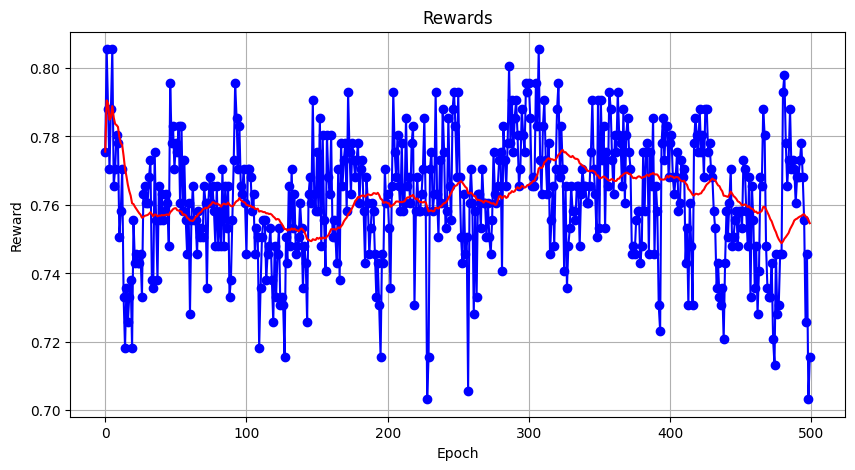

Best Feature set: ('darker', 'black', 'color_bin_1', 'color_bin_2', 'color_bin_4', 'color_bin_5', 'color_bin_6', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'rough', 'texture_0', 'texture_1', 'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'lengthy_aspect_ratio', 'rel_length', 'hu_moment_2', 'hu_moment_4', 'hu_moment_5', 'hu_moment_6', 'hu_moment_7')
Reward: 0.8054862842892768

Repitition 0
Feature set: ['darker', 'gradient', 'reddish', 'metallic', 'colorful', 'black', 'black_thin', 'dominating_color', 'color_bin_1', 'color_bin_3', 'color_bin_4', 'color_bin_5', 'color_bin_7', 'color_bin_8', 'color_bin_9', 'color_entropy', 'texture_0', 'texture_1', 'texture_4', 'texture_6', 'texture_7', 'texture_8', 'texture_9', 'lengthy', 'number_lengthy_objects', 'rel_length', 'hu_moment_2', 'hu_moment_3', 'hu_moment_4', 'hu_moment_5', 'hu_moment_7'], 
Accuracy: 0.73644388398

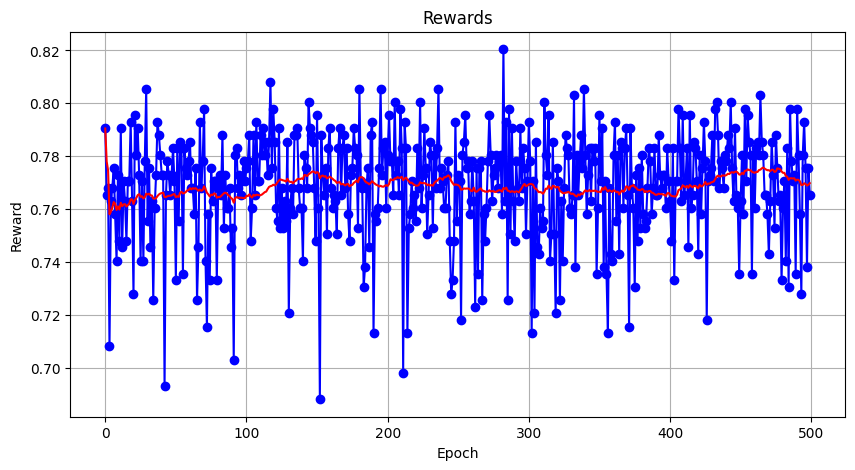

Best Feature set: ('darker', 'reddish', 'colorful', 'black', 'dominating_color', 'color_bin_1', 'color_bin_2', 'color_bin_3', 'color_bin_9', 'texture_0', 'texture_3', 'texture_4', 'texture_7', 'texture_9', 'rough_entropy', 'lengthy', 'number_lengthy_objects', 'rel_length', 'in_shape', 'hu_moment_2', 'hu_moment_4', 'hu_moment_6', 'hu_moment_7')
Reward: 0.8204488778054863



In [101]:
# Apply meta-learning and compare with random choices:

train_agent(drainage_classifier, initial_features=hypothesized_features_drainage, epochs=500)
random_monkey(drainage_classifier, repetitions=500)
